In [10]:
!pip install setuptools


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from urllib.parse import urlparse

# Load the dataset
df = pd.read_csv('urldata.csv')

# Inspect data
df.sample(100)


,Unnamed: 0,url,label,result
342591,342591,https://www.simplehelp.net/,benign,0
270531,270531,https://www.paperage.com/2009news/04_15_2009te...,benign,0
18423,18423,https://www.collegebasketball.rivals.com/conte...,benign,0
162862,162862,https://www.christies.com/LotFinder/lot_detail...,benign,0
403980,403980,http://rejoincomp2.in/3dv7n,malicious,1
...,...,...,...,...
77925,77925,https://www.myscottishfootball.blogspot.com/20...,benign,0
214470,214470,https://www.huffingtonpost.com/jonah-keri,benign,0
156512,156512,https://www.calvin.edu/academic/cas/gpa/ewig.htm,benign,0
318084,318084,https://www.videosurf.com/erin-moran-25050,benign,0


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Input, Embedding, GRU, Dense
from tensorflow.keras.optimizers import Adam

# Step 1: Prepare the data (0 for benign, 1 for phishing)

# Tokenize the URLs (character-level tokenization)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df['url'])

# Convert the URLs into sequences of integers
url_sequences = tokenizer.texts_to_sequences(df['url'])

# Pad the sequences to make them of equal length
max_sequence_length = 100  # can be adjusted based on data
X = pad_sequences(url_sequences, maxlen=max_sequence_length)

# Target labels
y = df['result'].values

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build the GRU model
vocab_size = len(tokenizer.word_index) + 1  # Total number of unique characters
embedding_dim = 50  # Size of the character embedding vectors

model = Sequential()

# Embedding layer (convert each character to a dense vector)
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# GRU layer
model.add(GRU(128, return_sequences=False))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test))

# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/5


C:\Users\tyler\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2814/2814 ━━━━━━━━━━━━━━━━━━━━ 173s 61ms/step - accuracy: 0.9331 - loss: 0.1687 - val_accuracy: 0.9919 - val_loss: 0.0274
Epoch 2/5
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 172s 61ms/step - accuracy: 0.9930 - loss: 0.0246 - val_accuracy: 0.9938 - val_loss: 0.0219
Epoch 3/5
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 173s 62ms/step - accuracy: 0.9946 - loss: 0.0196 - val_accuracy: 0.9937 - val_loss: 0.0218
Epoch 4/5
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 172s 61ms/step - accuracy: 0.9953 - loss: 0.0170 - val_accuracy: 0.9953 - val_loss: 0.0162
Epoch 5/5
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 168s 60ms/step - accuracy: 0.9962 - loss: 0.0142 - val_accuracy: 0.9959 - val_loss: 0.0152
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9961 - loss: 0.0152
Test Accuracy: 0.9959238767623901


In [5]:
# Save the trained GRU model
model.save('webapp_backend/model/phishing_gru_model.keras')

# Save the tokenizer using pickle
import pickle

with open('webapp_backend/model/gru_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [5]:
# Import required modules
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the saved GRU model in .keras format
model = load_model('webapp_backend/model/phishing_gru_model.keras')

# Example usage: Tokenizing a new URL
MAX_SEQUENCE_LENGTH = 100  # Same value used during training

In [6]:
from sklearn.metrics import roc_curve

# Example: Get prediction probabilities for a test dataset
y_prob = model.predict(X_test).flatten()

# Compute ROC curve and find the optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
optimal_idx = (tpr - fpr).argmax()  # Maximize TPR - FPR
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Use the new threshold in predictions
prediction = 'phishing' if y_prob[0] >= optimal_threshold else 'benign'
print(f"Prediction: {prediction} , {y_prob[0]}")


2814/2814 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step
Optimal Threshold: 0.19281911849975586
Prediction: phishing , 0.999997079372406


In [7]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\tyler\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
from imblearn.over_sampling import SMOTE

# Resample the training set using SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [9]:
from sklearn.metrics import classification_report

y_pred = (y_prob >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68921
           1       0.99      0.99      0.99     21115

    accuracy                           1.00     90036
   macro avg       0.99      0.99      0.99     90036
weighted avg       1.00      1.00      1.00     90036



In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# Example GRU model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=50, input_length=100))  # Embedding Layer
model.add(GRU(128, return_sequences=False))  # GRU Layer
model.add(Dense(1, activation='sigmoid'))  # Output Layer

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\tyler\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example URL
url = "http://gemmell.co.nz/view/"

# Tokenize the URL
sequence = tokenizer.texts_to_sequences([url])

# Pad the sequence to match the input length (100 in this case)
padded_sequence = pad_sequences(sequence, maxlen=100)

# Check the shape
print(padded_sequence.shape)  # Should be (1, 100)



(1, 100)


In [12]:
import numpy as np

# Expand the dimensions to make it (1, 100, 1)
input_data = np.expand_dims(padded_sequence, axis=-1)

# Check the shape
print(input_data.shape)  # Should be (1, 100, 1)


(1, 100, 1)


In [13]:
# Retrain the model with the corrected input
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Example prediction
prediction = model.predict(input_data)[0][0]
result = 'phishing' if prediction >= 0.5 else 'benign'
print(f"Prediction: {result}, Probability: {prediction}")


Epoch 1/2
11255/11255 ━━━━━━━━━━━━━━━━━━━━ 267s 24ms/step - accuracy: 0.9630 - loss: 0.1044 - val_accuracy: 0.9931 - val_loss: 0.0239
Epoch 2/2
11255/11255 ━━━━━━━━━━━━━━━━━━━━ 261s 23ms/step - accuracy: 0.9945 - loss: 0.0197 - val_accuracy: 0.9957 - val_loss: 0.0160
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9957 - loss: 0.0158
Test Accuracy: 0.995679497718811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Prediction: phishing, Probability: 0.9999727010726929


In [14]:
model.save('webapp_backend/model/phishing_gru_model.keras')
with open('webapp_backend/model/gru_tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [15]:
# Imports (Place all necessary imports at the top)
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the trained model
model = load_model('webapp_backend/model/phishing_gru_model.keras')

# Load the tokenizer
with open('webapp_backend/model/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

test_url = "example.com"
tokenized = tokenizer.texts_to_sequences([test_url])
print(tokenized)

# Define a function to predict a single URL
def predict_single_url(url, model, tokenizer, max_length=100):
    """Predict if a URL is phishing or benign using the trained GRU model."""
    # Tokenize and pad the sequence
    sequence = tokenizer.texts_to_sequences([url])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)
    print(padded_sequence.shape)
    print(f"Padded sequence in Journal: {padded_sequence}")

    # Predict using the model
    prediction = model.predict(padded_sequence)[0][0]
    print("Notebook Prediction (Raw):", prediction)
    confidence = 1 - prediction if prediction > 0.5 else prediction
    print("Notebook Confidence:", confidence)

    # Classify based on a threshold
    result = 'phishing' if prediction >= 0.5 else 'benign'

    # Display the result
    print(f"URL: {url} | Prediction: {result} | Probability: {prediction:.4f}")

# Example usage
print("Testing a single URL prediction:")
predict_single_url("http://gemmell.co.nz/view/", model, tokenizer)

# Optional: Test multiple URLs
def predict_multiple_urls(urls, model, tokenizer, max_length=100):
    """Predict phishing or benign for multiple URLs."""
    for url in urls:
        predict_single_url(url, model, tokenizer, max_length)

# Example with multiple URLs
urls_to_test = [
    "http://gemmell.co.nz/view/",
    "https://www.google.com",
    "http://fake-phish.com"
]
print("\nTesting multiple URLs:")
predict_multiple_urls(urls_to_test, model, tokenizer)



[[3, 37, 5, 15, 10, 16, 3, 7, 8, 4, 15]]
Testing a single URL prediction:
(1, 100)
Padded sequence in Journal: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0 14  2  2 10 22  1  1 21  3 15 15  3 16 16  7  8  4  7 11 41  1 33
   9  3 12  1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Notebook Prediction (Raw): 0.9937626
Notebook Confidence: 0.0062373877
URL: http://gemmell.co.nz/view/ | Prediction: phishing | Probability: 0.9938

Testing multiple URLs:
(1, 100)
Padded sequence in Journal: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0 14  2  2 10 22  1  1 21  3 15 15  3 16 16  7  8  4  7 11 41  1 33
   9  3 12  1]]
1/1 ━━━━━━━━━━━━━

In [18]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
history = model.fit(
    X_train, y_train, 
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=10, 
    batch_size=32
)


Epoch 1/10
 363/9004 ━━━━━━━━━━━━━━━━━━━━ 7:27 52ms/step - accuracy: 0.9953 - loss: 0.0132

KeyboardInterrupt: 

In [16]:


def plot_training_history(history):
    plt.figure(figsize=(8, 6))
    
    # Plot the accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    
    # Add labels and legend
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage: assuming you have a 'history' object
plot_training_history(history)



NameError: name 'history' is not defined

2814/2814 ━━━━━━━━━━━━━━━━━━━━ 78s 28ms/step


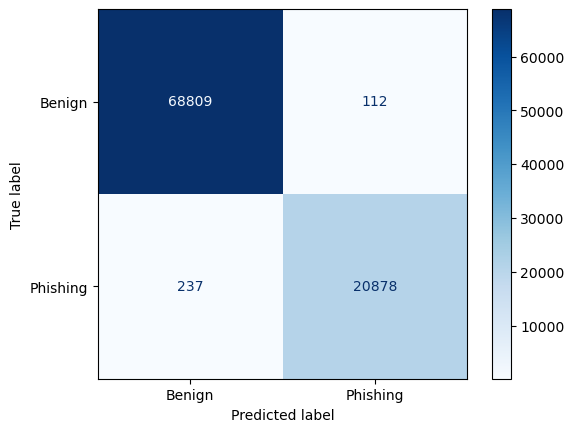

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# step 1: make predictions on test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# step 2: gererate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# step 3: display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign","Phishing"])
disp.plot(cmap="Blues", values_format='d')

Epoch 1/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 904s 100ms/step - accuracy: 0.9959 - loss: 0.0150 - val_accuracy: 0.9965 - val_loss: 0.0128
Epoch 2/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 886s 98ms/step - accuracy: 0.9970 - loss: 0.0109 - val_accuracy: 0.9971 - val_loss: 0.0118
Epoch 3/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 941s 105ms/step - accuracy: 0.9977 - loss: 0.0090 - val_accuracy: 0.9969 - val_loss: 0.0118
Epoch 4/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 949s 105ms/step - accuracy: 0.9980 - loss: 0.0078 - val_accuracy: 0.9968 - val_loss: 0.0123
Epoch 5/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 964s 103ms/step - accuracy: 0.9982 - loss: 0.0069 - val_accuracy: 0.9971 - val_loss: 0.0119
Epoch 6/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 1018s 107ms/step - accuracy: 0.9984 - loss: 0.0061 - val_accuracy: 0.9969 - val_loss: 0.0113
Epoch 7/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 975s 106ms/step - accuracy: 0.9984 - loss: 0.0060 - val_accuracy: 0.9969 - val_loss: 0.0120
Epoch 8/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 945s 105ms/step - ac

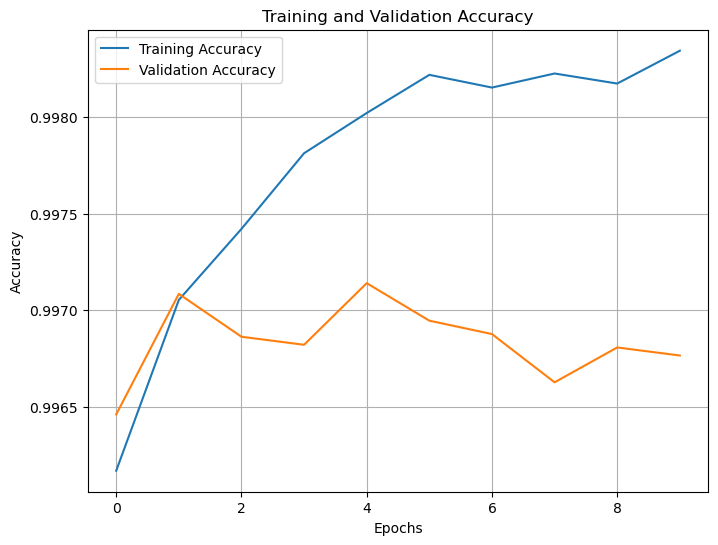

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
history = model.fit(
    X_train, y_train, 
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=10, 
    batch_size=32
)

def plot_training_history(history):
    plt.figure(figsize=(8, 6))
    
    # Plot the accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    
    # Add labels and legend
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage: assuming you have a 'history' object
plot_training_history(history)
